# Heurística de despacho de buses

Este cuaderno desarrolla la heurística para el despacho dinámico de autobuses en un sistema de transporte público. A partir de la demanda predicha (obtenida en el cuaderno de predicción de demanda), se simula la operación de la flota a lo largo de una jornada, despachando buses según parámetros operativos (umbral mínimo de ocupación y tiempo máximo de espera).

**Estructura del cuaderno:**
1. [Configuraciones e importaciones](#1-configuraciones-e-importaciones)
2. [Preparación de datos y configuración de rutas](#2-preparacion-de-datos-y-configuracion-de-rutas)
3. [Definición de funciones auxiliares](#3-definición-de-funciones-auxiliares)
4. [Función principal de simulación](#4-función-principal-de-simulación)
5. [Análisis de sensibilidad](#5-análisis-de-sensibilidad)
6. [Selección de parámetros óptimos](#6-selección-de-parámetros-óptimos)
7. [Ejecución final con parámetros óptimos](#7-ejecución-final-con-parámetros-óptimos)
8. [Visualizaciones finales](#8-visualizaciones-finales)
9. [Dudas frecuentes](#8-Dudas-frecuentes)

**Manual de uso para operadores**

1. **Montar Google Drive**  
   - Verificar que el acceso a Google Drive esté configurado para que el cuaderno pueda leer y guardar archivos.
   - Ajusta la ruta del archivo CSV según corresponda (`ruta_archivo`).

2. **Verificar parámetros globales**  
   - En la sección 1, revisar que las variables intervalo_minutos, hora_inicio y hora_fin coincidan con el horario de operación y que el intervalo sea el mismo definido en los pronósticos.

   - Configurar `costo_pasaje` y `costo_operacion`, que reflejan la tarifa al pasajero y el costo por minuto de tener un bus en operación (fuera de patio), respectivamente.

3. **Configurar las rutas**  
   - En la sección 2, revisar la función `crear_configuracion_rutas()` y adaptar los parámetros correspondientes a cada ruta:
     - `buses_totales`, `capacidad_bus`, `tmin`, `tprom`, `tmax`, `distancia_recorrido`, etc.  
     - Si se desea añadir rutas nuevas o eliminar alguna incluirla o eliminarla del diccionario.

4. **Cargar y revisar la demanda**  
   - El cuaderno utiliza un CSV consolidado (por defecto en la ruta pronosticos_futuros_consolidados.csv) con los pronósticos generados en el cuaderno anterior de predicción de demanda.
   - Validar que las columnas y los identificadores de rutas/sentidos en el CSV coincidan con los definidos en crear_configuracion_rutas().

6. **Análisis de sensibilidad**  
   - Ejecutar la celda que recorre los rangos de `umbrales_despacho` y `tiempos_max_espera`. Puede ajustarlos en caso de que quiera explorar comportamientos mas extremos.
   - Este paso puede llevar tiempo de cómputo según la cantidad de combinaciones.

7. **Selección de parámetros óptimos**  
   - El cuaderno prioriza el nivel de servicio (porcentaje de demanda atendida) como objetivo principal, y en caso de empates, se usa una Métrica Compuesta (ponderación de ocupación promedio, utilización de la flota, etc.). Puede ajustar estas prioridades según sus intereses en la operación.
   - Para cada ruta, se identifican el umbral de despacho y el tiempo máximo de espera que alcanzan el mejor equilibrio entre servicio y eficiencia.

8. **Ejecución final**  
   - Corra la simulación final para obtener los DataFrames de métricas y las visualizaciones de interes para observar la programación de despacho de buses para cada ruta más eficiente encontrada por la heurística.


## 1. Configuraciones e importaciones

In [ ]:
# ==================================
# 1. Configuraciones e Importaciones
# ==================================

import pandas as pd
import numpy as np
import math, random, time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import itertools
import copy

# Estilo de las gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

## 2. Preparación de datos y configuración de rutas

En esta sección se cargan los datos de demanda predicha y se crea la configuración base para cada ruta incluida en el sistema.

### Configuración global de la simulación
Los parámetros globales establecidos son:
- 'intervalo_minutos': tamaño del paso de simulación en minutos.
- 'hora_inicio' y 'hora_fin': determinan el rango horario de la operación.
- 'costo_pasaje': costo del tiquete de pasaje de pasajero común para todas las rutas.
- 'costo_operacion': costo por minuto de mantener un bus operando en alguna ruta, entiendase operando como por fuera del patio.

Esta configuración debe estar alineada con las condiciones establecidas en el modelo de predicción.


In [ ]:
# ==================================
# 2. Preparación de Datos y Configuración de Rutas
# ==================================

# Configuración global de la simulación
intervalo_minutos = 10
hora_inicio = datetime.strptime("05:00:00", "%H:%M:%S")
hora_fin = datetime.strptime("21:00:00", "%H:%M:%S")
costo_pasaje=2
costo_operacion=5

### Configuración de rutas
- Para cada ruta (ej. 'PRADERA 27', 'PANZENU', etc.), se definen los siguientes parámetros principales:
   1. **sentidos**: lista de sentidos (1 y 2).
   2. **buses_totales**: número total de buses disponibles para esa ruta.
   3. **capacidad_bus**: capacidad (en número de pasajeros) de cada bus.
   4. **tmin**, **tprom**, **tmax**: tiempos mínimos, promedio y máximos de recorrido para cada sentido (en minutos). Se utilizan para generar un tiempo de recorrido aproximado con distribución triangular, en caso de querer trabajar unicamente con los valores promedio definir los tres tiempos con el mismo valor(constante)
   5. **distancia_recorrido**: distancia (en km) de la ruta en cada sentido; esto se usa para calcular km recorridos.
   6. **tiempo_patio_cabecera** y **tiempo_cabecera_patio**: tiempos de viaje entre el patio y las cabeceras (en minutos).
   7. **limite_horas_operacion**: límite de horas de operación de un bus antes de requerir mantenimiento (por el momento inactivo dada la instrucción).
   8. **tiempo_mantenimiento**: tiempo que pasa un bus en mantenimiento antes de volver a estar disponible.
   9. **demanda_predicha**: diccionario donde, para cada sentido, se almacenará la serie de demanda pronosticada.
   10. **variables internas** como 'buses', 'demanda_acumulada', 'demanda_no_satisfecha', 'registros', que se irán llenando durante la simulación.

Se debe adaptar esta configuración a la realidad del sistema que se quiera simular (tiempos, distancias, buses, etc.). Cualquier cambio en las rutas se debe hacer aquí antes de ejecutar la simulación.


In [ ]:
def crear_configuracion_rutas():
    """
    Crea la configuración base de las rutas en el sistema.
    Esta configuración puede ser ampliada con las demás rutas según se requiera.
    """
    return  {
    'PRADERA 27': {
        'sentidos': [1, 2],
        'buses_totales': 8,
        'capacidad_bus': 52,
        'tiempo_fin_servicio': timedelta(minutes=0),
        'tmin': {1: 41, 2: 39},
        'tprom': {1: 41, 2: 39},
        'tmax': {1: 41, 2: 39},
        'distancia_recorrido': {1: 20.5, 2: 19.5},
        'tiempo_patio_cabecera': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'tiempo_cabecera_patio': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'limite_horas_operacion': timedelta(hours=24),
        'tiempo_mantenimiento': timedelta(hours=1),
        'demanda_predicha': {},
        'buses': [],
        'demanda_acumulada': {},
        'demanda_no_satisfecha': {},
        'horas': {},
        'demanda_no_satisfecha_por_intervalo': {},
        'registros': [],
    },
    'PANZENU': {
        'sentidos': [1, 2],
        'buses_totales': 7,
        'capacidad_bus': 52,
        'tiempo_fin_servicio': timedelta(minutes=0),
        'tmin': {1: 39, 2: 36},
        'tprom': {1: 39, 2: 36},
        'tmax': {1: 39, 2: 36},
        'distancia_recorrido': {1: 19.5, 2: 18},
        'tiempo_patio_cabecera': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'tiempo_cabecera_patio': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'limite_horas_operacion': timedelta(hours=24),
        'tiempo_mantenimiento': timedelta(hours=1),
        'demanda_predicha': {},
        'buses': [],
        'demanda_acumulada': {},
        'demanda_no_satisfecha': {},
        'horas': {},
        'demanda_no_satisfecha_por_intervalo': {},
        'registros': [],
    },
    'SANTANDER': {
        'sentidos': [1, 2],
        'buses_totales': 7,
        'capacidad_bus': 52,
        'tiempo_fin_servicio': timedelta(minutes=0),
        'tmin': {1: 49, 2: 47},
        'tprom': {1: 49, 2: 47},
        'tmax': {1: 49, 2: 47},
        'distancia_recorrido': {1: 24.5, 2: 23.5},
        'tiempo_patio_cabecera': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'tiempo_cabecera_patio': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'limite_horas_operacion': timedelta(hours=24),
        'tiempo_mantenimiento': timedelta(hours=1),
        'demanda_predicha': {},
        'buses': [],
        'demanda_acumulada': {},
        'demanda_no_satisfecha': {},
        'horas': {},
        'demanda_no_satisfecha_por_intervalo': {},
        'registros': [],
    },
    'MOGAMBO 22': {
        'sentidos': [1, 2],
        'buses_totales': 7,
        'capacidad_bus': 52,
        'tiempo_fin_servicio': timedelta(minutes=0),
        'tmin': {1: 28, 2: 29},
        'tprom': {1: 28, 2: 29},
        'tmax': {1: 28, 2: 29},
        'distancia_recorrido': {1: 14, 2: 14.5},
        'tiempo_patio_cabecera': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'tiempo_cabecera_patio': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'limite_horas_operacion': timedelta(hours=24),
        'tiempo_mantenimiento': timedelta(hours=1),
        'demanda_predicha': {},
        'buses': [],
        'demanda_acumulada': {},
        'demanda_no_satisfecha': {},
        'horas': {},
        'demanda_no_satisfecha_por_intervalo': {},
        'registros': [],
    },
    'TAMBO CIRCUNVALAR': {
        'sentidos': [1, 2],
        'buses_totales': 5,
        'capacidad_bus': 52,
        'tiempo_fin_servicio': timedelta(minutes=0),
        'tmin': {1: 39, 2: 34},
        'tprom': {1: 39, 2: 34},
        'tmax': {1: 39, 2: 34},
        'distancia_recorrido': {1: 19.5, 2: 17},
        'tiempo_patio_cabecera': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'tiempo_cabecera_patio': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'limite_horas_operacion': timedelta(hours=24),
        'tiempo_mantenimiento': timedelta(hours=1),
        'demanda_predicha': {},
        'buses': [],
        'demanda_acumulada': {},
        'demanda_no_satisfecha': {},
        'horas': {},
        'demanda_no_satisfecha_por_intervalo': {},
        'registros': [],
    },
    'KM30': {
        'sentidos': [1, 2],
        'buses_totales': 1,
        'capacidad_bus': 52,
        'tiempo_fin_servicio': timedelta(minutes=0),
        'tmin': {1: 40, 2: 34},
        'tprom': {1: 40, 2: 34},
        'tmax': {1: 40, 2: 34},
        'distancia_recorrido': {1: 20, 2: 17},
        'tiempo_patio_cabecera': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'tiempo_cabecera_patio': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'limite_horas_operacion': timedelta(hours=24),
        'tiempo_mantenimiento': timedelta(hours=1),
        'demanda_predicha': {},
        'buses': [],
        'demanda_acumulada': {},
        'demanda_no_satisfecha': {},
        'horas': {},
        'demanda_no_satisfecha_por_intervalo': {},
        'registros': [],
    },
    'DORADO': {
        'sentidos': [1, 2],
        'buses_totales': 7,
        'capacidad_bus': 52,
        'tiempo_fin_servicio': timedelta(minutes=0),
        'tmin': {1: 30, 2: 30},
        'tprom': {1: 30, 2: 30},
        'tmax': {1: 30, 2: 30},
        'distancia_recorrido': {1: 15, 2: 15},
        'tiempo_patio_cabecera': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'tiempo_cabecera_patio': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'limite_horas_operacion': timedelta(hours=24),
        'tiempo_mantenimiento': timedelta(hours=1),
        'demanda_predicha': {},
        'buses': [],
        'demanda_acumulada': {},
        'demanda_no_satisfecha': {},
        'horas': {},
        'demanda_no_satisfecha_por_intervalo': {},
        'registros': [],
    },
    'KM 15': {
        'sentidos': [1, 2],
        'buses_totales': 2,
        'capacidad_bus': 52,
        'tiempo_fin_servicio': timedelta(minutes=0),
        'tmin': {1: 24, 2: 22},
        'tprom': {1: 24, 2: 22},
        'tmax': {1: 24, 2: 22},
        'distancia_recorrido': {1: 12, 2: 11},
        'tiempo_patio_cabecera': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'tiempo_cabecera_patio': {1: timedelta(minutes=15), 2: timedelta(minutes=15)},
        'limite_horas_operacion': timedelta(hours=24),
        'tiempo_mantenimiento': timedelta(hours=1),
        'demanda_predicha': {},
        'buses': [],
        'demanda_acumulada': {},
        'demanda_no_satisfecha': {},
        'horas': {},
        'demanda_no_satisfecha_por_intervalo': {},
        'registros': [],
    }
}


### Carga de la demanda predicha
- Se tiene un archivo CSV (por ejemplo 'pronosticos_futuros_consolidados.csv')
  con la información de demanda pronosticada por ruta y sentido generada en por el modelo de predicción. Esta se encuentra almacenada en Google Drive de manera automatica por lo que se accede al respectivo archivo.

In [ ]:
# Montaje de Google Drive (si se usa Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Cargar demanda predicha
ruta_archivo='/content/drive/MyDrive/Colab Notebooks/modelos_prophet/pronosticos/pronosticos_futuros_consolidados.csv'
demanda_predicha = pd.read_csv(ruta_archivo, index_col=0)

# Convertir el DataFrame a un diccionario, cada llave será el nombre de la ruta y el valor será una lista de los datos correspondientes
demanda_predicha = demanda_predicha.apply(lambda row: row.tolist(), axis=1).to_dict()

rutas_config_base = crear_configuracion_rutas()

Mounted at /content/drive


## 3. Definición de funciones auxiliares

En esta sección se definen las funciones auxiliares necesarias para la lógica de la simulación:

- **generar_tiempo_recorrido**: genera el tiempo de recorrido de un bus entre cabeceras, siguiendo una distribución triangular.
- **evaluar_necesidad_en_cabecera**: determina si es necesario mantener el bus en la cabecera según la demanda futura.
- **evaluar_demanda_en_cabecera_opuesta**: evalúa la conveniencia de enviar un bus vacío a la cabecera opuesta.
- **enviar_bus_en_vacio**, **enviar_bus_al_patio**, **enviar_bus_desde_patio**: gestionan el movimiento de buses entre cabeceras y patio.
- **evaluar_buses_ociosos**: evalúa y redistribuye los buses ociosos entre cabeceras o patio.
- **enviar_buses_al_patio_al_finalizar_operacion**: asegura que todos los buses regresen al patio al final del día.
- **calcular_metricas**: calcula las métricas finales por bus y por ruta (nivel de servicio, utilidad, ocupación, etc.).


In [ ]:
# ==================================
# 3. Definición de Funciones Auxiliares
# ==================================

def generar_tiempo_recorrido(ruta_config, sentido):
    """
    Genera un tiempo de recorrido variable para un bus usando una distribución triangular.

    Parámetros:
    - ruta_config (dict): Configuración de la ruta.
    - sentido (int): Sentido de la ruta (1 o 2).

    Retorna:
    - timedelta: Tiempo de recorrido generado.
    """
    tmin = ruta_config['tmin'][sentido]
    tprom = ruta_config['tprom'][sentido]
    tmax = ruta_config['tmax'][sentido]
    tiempo = random.triangular(tmin, tprom, tmax)
    return timedelta(minutes=tiempo)

def evaluar_necesidad_en_cabecera(bus, hora_actual, indice_actual, sentido, ruta_config):
    """
    Determina si es necesario mantener el bus en la cabecera en función de la demanda futura.

    Parámetros:
    - bus (dict): Diccionario que representa al bus.
    - hora_actual (datetime): Hora actual de la simulación.
    - indice_actual (int): Índice del intervalo de tiempo actual.
    - sentido (int): Sentido de la ruta (1 o 2).
    - ruta_config (dict): Configuración de la ruta.

    Retorna:
    - bool: True si se requiere mantener el bus (hay demanda futura insatisfecha), False si no.
    """
    intervalos_futuros = int(ruta_config['tiempo_max_espera'].total_seconds() // (intervalo_minutos * 60))
    demanda_futura = sum(ruta_config['demanda_predicha'][sentido][indice_actual+1 : indice_actual + intervalos_futuros])

    buses_en_cabecera = [
        b for b in ruta_config['buses']
        if b["status"] == f"en_cabecera_{sentido}"
        and b["disponible_a"] <= hora_actual
        and b["id"] != bus["id"]
    ]
    capacidad_total = len(buses_en_cabecera) * ruta_config['capacidad_bus']
    return capacidad_total < demanda_futura

def evaluar_demanda_en_cabecera_opuesta(hora_actual, indice_actual, sentido_actual, tiempo_recorrido, ruta_config, hora_inicio, intervalo_minutos):
    """
    Evalúa la conveniencia de enviar un bus vacío a la cabecera opuesta según la demanda futura.

    Parámetros:
    - hora_actual (datetime): Hora actual de la simulación.
    - indice_actual (int): Índice de intervalo actual.
    - sentido_actual (int): Sentido actual (1 o 2).
    - tiempo_recorrido (timedelta): Tiempo de traslado entre cabeceras.
    - ruta_config (dict): Configuración de la ruta.
    - hora_inicio (datetime): Hora de inicio de la operación.
    - intervalo_minutos (int): Duración de cada intervalo en minutos.

    Retorna:
    - bool: True si conviene enviar el bus a la cabecera opuesta, False en caso contrario.
    """
    hora_llegada = hora_actual + tiempo_recorrido
    indice_llegada = int((hora_llegada - hora_inicio).total_seconds() // (intervalo_minutos * 60))
    intervalos_futuros = int(ruta_config['tiempo_max_espera'].total_seconds() // (intervalo_minutos * 60))

    sentido_opuesto = 2 if sentido_actual == 1 else 1
    demanda_futura = sum(ruta_config['demanda_predicha'][sentido_opuesto][indice_llegada : indice_llegada + intervalos_futuros])

    buses_en_cabecera_opuesta = [
        b for b in ruta_config['buses']
        if b["status"] == f"en_cabecera_{sentido_opuesto}"
        and b["disponible_a"] <= hora_llegada
    ]
    capacidad_total = len(buses_en_cabecera_opuesta) * ruta_config['capacidad_bus']
    return capacidad_total < demanda_futura

def enviar_bus_en_vacio(bus, hora_actual, sentido_actual, ruta_config):
    """
    Envía un bus en vacío a la cabecera opuesta.

    Parámetros:
    - bus (dict): Bus a enviar.
    - hora_actual (datetime): Hora actual.
    - sentido_actual (int): Sentido actual (1 o 2).
    - ruta_config (dict): Configuración de la ruta.
    """
    sentido_opuesto = 2 if sentido_actual == 1 else 1
    estado_vacio = f"en_vacio_{sentido_actual}_a_{sentido_opuesto}"
    cabecera_destino = f"en_cabecera_{sentido_opuesto}"

    tiempo_recorrido = generar_tiempo_recorrido(ruta_config, sentido_actual)
    ruta_config['registros'].append([bus["id"], bus["status"], bus["disponible_a"], hora_actual])
    bus["status"] = estado_vacio
    ruta_config['registros'].append([bus["id"], estado_vacio, hora_actual, hora_actual + tiempo_recorrido])
    bus["disponible_a"] = hora_actual + tiempo_recorrido
    bus["status"] = cabecera_destino
    bus["disponible_a"] += ruta_config['tiempo_fin_servicio']

def enviar_bus_al_patio(bus, hora_actual, sentido_actual, ruta_config):
    """
    Envía un bus de vuelta al patio desde la cabecera.
    """
    ruta_config['registros'].append([bus["id"], bus["status"], bus["disponible_a"], hora_actual])
    tiempo_transito = ruta_config['tiempo_cabecera_patio'][sentido_actual]
    estado_transito = f"en_transito_cabecera_{sentido_actual}_patio"
    bus["status"] = estado_transito
    ruta_config['registros'].append([bus["id"], estado_transito, hora_actual, hora_actual + tiempo_transito])
    bus["disponible_a"] = hora_actual + tiempo_transito
    bus["status"] = "en_patio"
    bus["disponible_a"] += ruta_config['tiempo_fin_servicio']

def enviar_bus_desde_patio(bus, hora_salida, ruta_config, sentido):
    """
    Despacha un bus desde el patio hacia una cabecera.
    """
    tiempo_transito = ruta_config['tiempo_patio_cabecera'][sentido]
    estado_transito = f"en_transito_patio_cabecera_{sentido}"
    cabecera_destino = f"en_cabecera_{sentido}"

    ruta_config['registros'].append([bus["id"], "en_patio", bus["disponible_a"], hora_salida])
    bus["status"] = estado_transito
    ruta_config['registros'].append([bus["id"], estado_transito, hora_salida, hora_salida + tiempo_transito])
    bus["disponible_a"] = hora_salida + tiempo_transito
    bus["status"] = cabecera_destino
    bus["disponible_a"] += ruta_config['tiempo_fin_servicio']

def evaluar_buses_ociosos(ruta_config, hora_actual, indice_actual, hora_inicio, intervalo_minutos):
    """
    Evalúa y gestiona los buses ociosos en las cabeceras, enviándolos al patio o a la cabecera opuesta.
    """
    for sentido in ruta_config['sentidos']:
        cabecera = f"en_cabecera_{sentido}"
        buses_en_cabecera = [
            bus for bus in ruta_config['buses']
            if bus["status"] == cabecera
            and bus["disponible_a"] <= hora_actual
            and not bus["en_mantenimiento"]
        ]
        # Ordenar por disponibilidad
        buses_en_cabecera.sort(key=lambda x: x["disponible_a"], reverse=True)

        for bus in buses_en_cabecera:
            sera_necesario = evaluar_necesidad_en_cabecera(bus, hora_actual, indice_actual, sentido, ruta_config)
            if not sera_necesario:
                tiempo_recorrido = generar_tiempo_recorrido(ruta_config, sentido)
                enviar_a_cabecera_opuesta = evaluar_demanda_en_cabecera_opuesta(
                    hora_actual, indice_actual, sentido, tiempo_recorrido, ruta_config, hora_inicio, intervalo_minutos
                )
                if enviar_a_cabecera_opuesta:
                    enviar_bus_en_vacio(bus, hora_actual, sentido, ruta_config)
                else:
                    enviar_bus_al_patio(bus, hora_actual, sentido, ruta_config)

def enviar_buses_al_patio_al_finalizar_operacion(ruta_config, hora_fin):
    """
    Envía todos los buses que no estén en el patio o en mantenimiento de vuelta al patio al final de la jornada.
    """
    for bus in ruta_config['buses']:
        if bus["status"] not in ["en_patio", "en_mantenimiento"]:
            hora_actual = max(bus["disponible_a"], hora_fin)
            ruta_config['registros'].append([bus["id"], bus["status"], bus["disponible_a"], hora_actual])

            if "cabecera_1" in bus["status"]:
                tiempo_transito = ruta_config['tiempo_cabecera_patio'][1]
                estado_transito = "en_transito_cabecera_1_patio"
            elif "cabecera_2" in bus["status"]:
                tiempo_transito = ruta_config['tiempo_cabecera_patio'][2]
                estado_transito = "en_transito_cabecera_2_patio"
            else:
                continue

            bus["status"] = estado_transito
            ruta_config['registros'].append([bus["id"], estado_transito, hora_actual, hora_actual + tiempo_transito])
            bus["disponible_a"] = hora_actual + tiempo_transito
            bus["status"] = "en_patio"

def calcular_metricas(rutas_config, intervalo_minutos):
    """
    Calcula las métricas finales por bus y por ruta.

    Retorna:
    - df_metricas_buses (DataFrame): Métricas por bus.
    - df_metricas_rutas (DataFrame): Métricas por ruta.
    """
    estados_posibles = [
        "en_ruta_1", "en_ruta_2", "en_cabecera_1", "en_cabecera_2", "en_patio",
        "en_transito_patio_cabecera_1", "en_transito_patio_cabecera_2",
        "en_vacio_1_a_2", "en_vacio_2_a_1",
        "en_transito_cabecera_1_patio", "en_transito_cabecera_2_patio",
        "en_mantenimiento"
    ]

    metricas_buses = []
    for ruta, config in rutas_config.items():
        for bus in config['buses']:
            tiempos_por_estado = {estado: timedelta(0) for estado in estados_posibles}
            registros_bus = [r for r in config['registros'] if r[0] == bus['id']]

            for registro in registros_bus:
                estado = registro[1]
                hora_ini = registro[2]
                hora_fin_reg = registro[3]
                tiempo_estado = hora_fin_reg - hora_ini
                if estado in tiempos_por_estado:
                    tiempos_por_estado[estado] += tiempo_estado
                else:
                    tiempos_por_estado[estado] = tiempo_estado

            tiempo_total = sum(tiempos_por_estado.values(), timedelta())
            tiempo_total_en_patio = tiempos_por_estado["en_patio"]
            tiempo_uso = tiempo_total - tiempo_total_en_patio
            tiempo_quieto = (tiempos_por_estado["en_cabecera_1"] +
                             tiempos_por_estado["en_cabecera_2"] +
                             tiempos_por_estado["en_mantenimiento"])
            tiempo_movimiento = tiempo_uso - tiempo_quieto

            if bus["viajes_realizados"] > 0:
                capacidad_promedio_utilizada = bus["capacidad_utilizada_total"] / bus["viajes_realizados"]
            else:
                capacidad_promedio_utilizada = 0
            if bus["tiempo_en_ruta"].total_seconds() > 0 and tiempo_uso.total_seconds() > 0:
                utilizacion = (bus["tiempo_en_ruta"].total_seconds() / tiempo_uso.total_seconds()) * 100
            else:
                utilizacion = 0

            metricas_buses.append({
                "Ruta": ruta,
                "Bus ID": bus['id'],
                "Pasajeros Transportados": bus['pasajeros_transportados'],
                "Kilómetros Recorridos": bus['kilometros_recorridos'],
                "Viajes Realizados": bus['viajes_realizados'],
                "Capacidad Promedio Utilizada (%)": round(capacidad_promedio_utilizada, 2),
                "Horas de Operación": bus['tiempo_en_ruta'],
                "Utilización (%)": round(utilizacion, 2),
                "Tiempo Uso": tiempo_uso,
                "Tiempo Quieto": tiempo_quieto,
                "Tiempo en patio": tiempo_total_en_patio,
                "Tiempo en movimiento": tiempo_movimiento
            })

    df_metricas_buses = pd.DataFrame(metricas_buses)

    # Cálculo de métricas por ruta
    c_ingreso=costo_pasaje
    c_bus=costo_operacion/intervalo_minutos

    metricas_rutas = []
    for ruta, config in rutas_config.items():
        total_pasajeros = sum(bus["pasajeros_transportados"] for bus in config['buses'])
        viajes_realizados = sum(bus["viajes_realizados"] for bus in config['buses'])
        total_kilometros = sum(bus["kilometros_recorridos"] for bus in config['buses'])
        demanda_no_satisfecha_total = sum(config['demanda_no_satisfecha'].values())

        if (total_pasajeros + demanda_no_satisfecha_total) > 0:
            nivel_de_servicio = (total_pasajeros / (total_pasajeros + demanda_no_satisfecha_total))*100
        else:
            nivel_de_servicio = 0

        utilizacion_promedio = df_metricas_buses[df_metricas_buses["Ruta"] == ruta]["Utilización (%)"].mean()
        df_filtro = df_metricas_buses[(df_metricas_buses["Ruta"] == ruta) & (df_metricas_buses["Kilómetros Recorridos"] != 0)]
        capacidad_promedio_utilizada_bus = df_filtro["Capacidad Promedio Utilizada (%)"].mean() if not df_filtro.empty else 0
        tiempo_total_uso = df_metricas_buses[df_metricas_buses["Ruta"] == ruta]["Tiempo Uso"].sum()

        ingresos = c_ingreso*total_pasajeros
        costo_fijo = c_bus*(tiempo_total_uso.total_seconds()/60)
        utilidad = ingresos - costo_fijo

        IPK_global = (total_pasajeros/total_kilometros) if total_kilometros>0 else 0

        metricas_rutas.append({
            "Ruta": ruta,
            "Total Pasajeros": total_pasajeros,
            "Viajes Realizados": viajes_realizados,
            "Total Kilómetros": total_kilometros,
            "Demanda No Satisfecha": demanda_no_satisfecha_total,
            "Nivel de Servicio (%)": round(nivel_de_servicio, 2),
            "IPK Global": round(IPK_global, 2),
            "Utilización Promedio (%)": round(utilizacion_promedio, 2),
            "Capacidad Promedio Utilizada (%)": round(capacidad_promedio_utilizada_bus, 2),
            "Utilidad": utilidad
        })

    df_metricas_rutas = pd.DataFrame(metricas_rutas)

    return df_metricas_buses, df_metricas_rutas


## 4. Función principal de simulación

La función `ejecutar_simulacion` es el núcleo de la heurística de despacho:
integra la lógica de las funciones auxiliares y aplica la política de despacho
(umbral de ocupación y tiempo máximo de espera) a lo largo de toda la jornada.

### Parámetros principales de ejecutar_simulacion:

- umbral_porcentaje (int): el % mínimo de ocupación para despachar un bus desde una cabecera.
  (Ej. si capacidad_bus=50 y umbral=80%, el bus se despacha cuando se esperan al menos 40 pasajeros).
- tiempo_max_espera (int): tiempo máximo (en minutos) que se permite esperar para formar ocupación
  antes de despachar un bus aunque no se alcance el umbral.
- demanda_predicha (DataFrame o dict): la demanda predicha para cada ruta y sentido.
- rutas_config (dict): la configuración base de cada ruta (creada anteriormente).
- intervalo_minutos (int): define la granularidad de la simulación (ej. cada 10 minutos).
- hora_inicio y hora_fin (datetime): marcan el rango de operación.
  
La función recorre cada intervalo de tiempo y hace lo siguiente:
1. Actualiza la demanda acumulada para cada ruta y sentido.
2. Verifica si se cumple el umbral de ocupación o el tiempo máximo de espera para despachar un bus.
3. Si hay buses disponibles, los despacha. Si no, registra demanda no satisfecha.
4. Evalúa buses ociosos y decide si enviarlos en vacío a la otra cabecera o al patio.
5. Al finalizar todos los intervalos, envía los buses al patio.
6. Retorna DataFrames con métricas por bus y por ruta, así como tiempos computacionales.

In [ ]:
# ==================================
# 4. Función Principal de Simulación
# ==================================

def ejecutar_simulacion(umbral_porcentaje, tiempo_max_espera, demanda_predicha, rutas_config, intervalo_minutos, hora_inicio, hora_fin):
    """
    La función `ejecutar_simulacion` integra las funciones auxiliares y la configuración de las rutas. Dado un umbral de ocupación, un tiempo máximo de espera, la demanda predicha y la configuración, simula toda la jornada de operación. Al finalizar, retorna las métricas calculadas.

    Parámetros:
    - umbral_porcentaje (int): Umbral de ocupación mínimo (en porcentaje) para despachar un bus.
    - tiempo_max_espera (int): Tiempo máximo (en minutos) que se esperará antes de despachar un bus.
    - demanda_predicha (DataFrame): Datos de demanda predicha.
    - rutas_config (dict): Configuración de las rutas.
    - intervalo_minutos (int): Intervalo de tiempo de la simulación.
    - hora_inicio, hora_fin (datetime): Horas de inicio y fin de la operación.

    Retorna:
    - df_metricas_buses, df_metricas_rutas (DataFrame): Métricas por bus y por ruta.
    - tiempos_computacionales (dict): Tiempo de cómputo por ruta.

    """
    # Asignar umbral y tiempo de espera, e inicializar variables
    for ruta, config in rutas_config.items():
        config['umbral_porcentaje'] = umbral_porcentaje
        config['tiempo_max_espera'] = timedelta(minutes=tiempo_max_espera)
        for sentido in config['sentidos']:
            clave = f"{ruta}_sentido_{sentido}"
            if clave in demanda_predicha:
                config['demanda_predicha'][sentido] = demanda_predicha[clave]
            else:
                config['demanda_predicha'][sentido] = np.zeros(48)

        config['buses'] = [{
            "id": f"{ruta}_{i+1}",
            "status": "en_patio",
            "disponible_a": hora_inicio - max(config['tiempo_patio_cabecera'].values()),
            "pasajeros_transportados": 0,
            "kilometros_recorridos": 0,
            "viajes_realizados": 0,
            "capacidad_utilizada_total": 0,
            "horas_operacion": timedelta(0),
            "en_mantenimiento": False,
            "tiempo_en_ruta": timedelta(0),
        } for i in range(config['buses_totales'])]

        for sentido in config['sentidos']:
            config['demanda_acumulada'][sentido] = 0
            config['demanda_no_satisfecha'][sentido] = 0
            config['horas'][sentido] = []
            config['demanda_no_satisfecha_por_intervalo'][sentido] = []

    intervalos = int((hora_fin - hora_inicio).total_seconds() // (intervalo_minutos * 60))
    tiempos_computacionales = {ruta: 0.0 for ruta in rutas_config}

    for i in range(intervalos):
        hora_actual = hora_inicio + timedelta(minutes=i*intervalo_minutos)
        for ruta, config in rutas_config.items():
            start_time = time.perf_counter()
            for sentido in config['sentidos']:
                config['horas'][sentido].append(hora_actual)
                demanda_pred = config['demanda_predicha'][sentido]
                demanda_acum = config['demanda_acumulada'][sentido]
                demanda_acum += demanda_pred[i % len(demanda_pred)]
                config['demanda_acumulada'][sentido] = demanda_acum

                capacidad_bus = config['capacidad_bus']
                umbral_despacho = capacidad_bus * config['umbral_porcentaje'] // 100
                tmin = config['tmin'][sentido]
                tiempo_fin_servicio = config['tiempo_fin_servicio']

                if (demanda_acum >= umbral_despacho or
                    len(config['horas'][sentido]) >= math.ceil(tmin/intervalo_minutos) or
                    i == intervalos - 1):
                    hora_ini_acum = config['horas'][sentido][0]
                    cabecera = f"en_cabecera_{sentido}"
                    bus_disponible = next(
                        (bus for bus in config['buses']
                         if bus["status"] == cabecera
                         and bus["disponible_a"] <= hora_ini_acum
                         and not bus["en_mantenimiento"]),
                        None
                    )

                    if bus_disponible:
                        # Despachar bus desde cabecera
                        config['registros'].append([bus_disponible["id"], bus_disponible["status"], bus_disponible["disponible_a"], hora_ini_acum])
                        tiempo_recorrido = generar_tiempo_recorrido(config, sentido)
                        bus_disponible["status"] = f"en_ruta_{sentido}"
                        config['registros'].append([bus_disponible["id"], f"en_ruta_{sentido}", hora_ini_acum, hora_ini_acum + tiempo_recorrido])
                        bus_disponible["disponible_a"] = hora_ini_acum + tiempo_recorrido
                        demanda_atendida = min(capacidad_bus, demanda_acum)
                        bus_disponible["pasajeros_transportados"] += demanda_atendida
                        bus_disponible["kilometros_recorridos"] += config['distancia_recorrido'][sentido]
                        bus_disponible["viajes_realizados"] += 1
                        porcentaje_ocupacion = (demanda_atendida / capacidad_bus) * 100
                        bus_disponible["capacidad_utilizada_total"] += porcentaje_ocupacion
                        bus_disponible["horas_operacion"] += tiempo_recorrido
                        bus_disponible["tiempo_en_ruta"] += tiempo_recorrido
                        sentido_opuesto = 2 if sentido == 1 else 1
                        bus_disponible["status"] = f"en_cabecera_{sentido_opuesto}"
                        bus_disponible["disponible_a"] += tiempo_fin_servicio

                        if bus_disponible["horas_operacion"] >= config['limite_horas_operacion']:
                            bus_disponible["status"] = "en_mantenimiento"
                            config['registros'].append([bus_disponible["id"], "en_mantenimiento", bus_disponible["disponible_a"], bus_disponible["disponible_a"] + config['tiempo_mantenimiento']])
                            bus_disponible["disponible_a"] += config['tiempo_mantenimiento']
                            bus_disponible["horas_operacion"] = timedelta(0)
                            bus_disponible["en_mantenimiento"] = True
                            bus_disponible["status"] = "en_patio"
                            bus_disponible["en_mantenimiento"] = False

                        demanda_acum -= demanda_atendida
                        config['demanda_acumulada'][sentido] = demanda_acum
                        if demanda_acum > 0:
                            config['horas'][sentido] = config['horas'][sentido][-1:]
                        else:
                            config['horas'][sentido] = []
                    else:
                        # Intentar desde el patio
                        bus_patio = next(
                            (bus for bus in config['buses']
                             if bus["status"] == "en_patio"
                             and bus["disponible_a"] <= hora_ini_acum - config['tiempo_patio_cabecera'][sentido]
                             and not bus["en_mantenimiento"]),
                            None
                        )
                        if bus_patio:
                            enviar_bus_desde_patio(bus_patio, hora_ini_acum - config['tiempo_patio_cabecera'][sentido], config, sentido)
                            config['registros'].append([bus_patio["id"], bus_patio["status"], bus_patio["disponible_a"], hora_ini_acum])
                            tiempo_recorrido = generar_tiempo_recorrido(config, sentido)
                            bus_patio["status"] = f"en_ruta_{sentido}"
                            config['registros'].append([bus_patio["id"], f"en_ruta_{sentido}", hora_ini_acum, hora_ini_acum + tiempo_recorrido])
                            bus_patio["disponible_a"] = hora_ini_acum + tiempo_recorrido
                            demanda_atendida = min(capacidad_bus, demanda_acum)
                            bus_patio["pasajeros_transportados"] += demanda_atendida
                            bus_patio["kilometros_recorridos"] += config['distancia_recorrido'][sentido]
                            bus_patio["viajes_realizados"] += 1
                            porcentaje_ocupacion = (demanda_atendida / capacidad_bus) * 100
                            bus_patio["capacidad_utilizada_total"] += porcentaje_ocupacion
                            bus_patio["horas_operacion"] += tiempo_recorrido
                            bus_patio["tiempo_en_ruta"] += tiempo_recorrido
                            sentido_opuesto = 2 if sentido == 1 else 1
                            bus_patio["status"] = f"en_cabecera_{sentido_opuesto}"
                            bus_patio["disponible_a"] += tiempo_fin_servicio

                            if bus_patio["horas_operacion"] >= config['limite_horas_operacion']:
                                bus_patio["status"] = "en_mantenimiento"
                                config['registros'].append([bus_patio["id"], "en_mantenimiento", bus_patio["disponible_a"], bus_patio["disponible_a"] + config['tiempo_mantenimiento']])
                                bus_patio["disponible_a"] += config['tiempo_mantenimiento']
                                bus_patio["horas_operacion"] = timedelta(0)
                                bus_patio["en_mantenimiento"] = True
                                bus_patio["status"] = "en_patio"
                                bus_patio["en_mantenimiento"] = False
                            demanda_acum -= demanda_atendida
                            config['demanda_acumulada'][sentido] = demanda_acum
                            if demanda_acum > 0:
                                config['horas'][sentido] = config['horas'][sentido][-1:]
                            else:
                                config['horas'][sentido] = []
                        else:
                            # No hay buses disponibles
                            config['demanda_no_satisfecha'][sentido] += demanda_acum
                            config['demanda_acumulada'][sentido] = 0
                            config['horas'][sentido] = []

                config['demanda_no_satisfecha_por_intervalo'][sentido].append(config['demanda_no_satisfecha'][sentido])

            evaluar_buses_ociosos(config, hora_actual, i, hora_inicio, intervalo_minutos)
            end_time = time.perf_counter()
            tiempos_computacionales[ruta] += (end_time - start_time)

    # Finalizar: enviar buses al patio
    for ruta, config in rutas_config.items():
        enviar_buses_al_patio_al_finalizar_operacion(config, hora_fin)

    df_metricas_buses, df_metricas_rutas = calcular_metricas(rutas_config, intervalo_minutos)
    return df_metricas_buses, df_metricas_rutas, tiempos_computacionales


## 5. Análisis de sensibilidad (exploración de escenarios)

Se analizan múltiples combinaciones de parámetros (umbral de despacho y tiempo máximo de espera) para encontrar aquella que maximiza una métrica de interes, en este caso la utilidad, definida como la diferencia entre los ingresos generados por la venta de pasajes y el costo por tener el bus en operación. Además, se considera una métrica compuesta para desempates.

### Metodología
1. Se definen rangos para 'umbrales_despacho' (por ejemplo, 10% a 100%) y para 'tiempos_max_espera' (por ejemplo, 0 a 60 minutos).
2. Se generan todas las combinaciones posibles (producto cartesiano) de esos dos rangos.
3. Por cada combinación (escenario):
   - Se hace una copia de la configuración de rutas (para no sobreescribir el estado).
   - Se corre la simulación llamando a `ejecutar_simulacion`.
   - Se registran las métricas resultantes (utilidad, nivel de servicio, etc.).
4. Finalmente, se consolida todo en un DataFrame (`df_resultados`) y se visualiza la relación entre la utilidad y estos parámetros.

Este análisis permite identificar tendencias y valores apropiados de umbral de despacho y tiempo de espera. En general, al aumentar el umbral, se pueden despachar buses más llenos (optimizando capacidad), pero podría aumentar la demanda no satisfecha. Al aumentar el tiempo de espera, también se puede elevar la ocupación media, pero se corre el riesgo de que los pasajeros esperen demasiado, afectando el nivel de servicio y la satisfacción del usuario.


In [ ]:
umbrales_despacho = [x for x in range(10, 101, 2)]
tiempos_max_espera = [x for x in range(0, 61, 2)]
escenarios = list(itertools.product(umbrales_despacho, tiempos_max_espera))

resultados = []

for umbral, t_espera in escenarios:
    rutas_config_escenario = copy.deepcopy(rutas_config_base)
    start_sim = time.perf_counter()
    df_metricas_buses, df_metricas_rutas, tiempos_comp = ejecutar_simulacion(
        umbral,
        t_espera,
        demanda_predicha,
        rutas_config_escenario,
        intervalo_minutos,
        hora_inicio,
        hora_fin
    )
    end_sim = time.perf_counter()
    tiempo_total = end_sim - start_sim
    for idx, row in df_metricas_rutas.iterrows():
        resultados.append({
            'Ruta': row['Ruta'],
            'Umbral Despacho (%)': umbral,
            'Tiempo Máximo Espera (min)': t_espera,
            'Total Pasajeros': row['Total Pasajeros'],
            'Total Kilómetros': row['Total Kilómetros'],
            'Demanda No Satisfecha': row['Demanda No Satisfecha'],
            'Nivel de Servicio (%)': row['Nivel de Servicio (%)'],
            'IPK Global': row['IPK Global'],
            'Utilización Promedio (%)': row['Utilización Promedio (%)'],
            'Capacidad Promedio (%)': row['Capacidad Promedio Utilizada (%)'],
            'Utilidad': row['Utilidad'],
            'Tiempo Total Simulación (s)': tiempo_total
        })

df_resultados = pd.DataFrame(resultados)


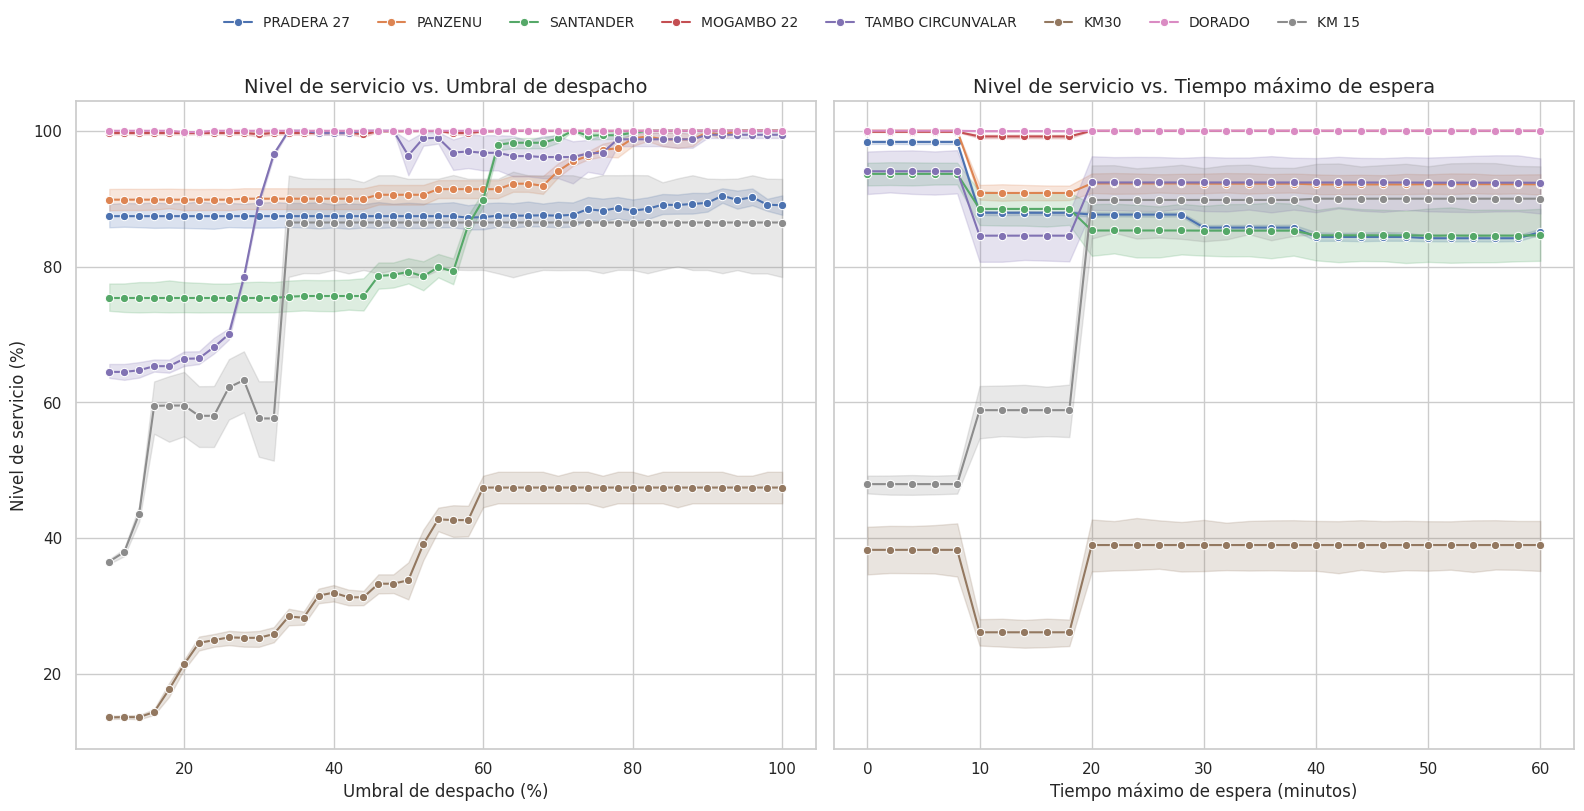

In [ ]:
# Columnas sean de tipo numérico
df_resultados['Umbral Despacho (%)'] = pd.to_numeric(df_resultados['Umbral Despacho (%)'])
df_resultados['Tiempo Máximo Espera (min)'] = pd.to_numeric(df_resultados['Tiempo Máximo Espera (min)'])

# Crear subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Gráfico 1: Nivel de servicio vs. Umbral de despacho
sns.lineplot(
    data=df_resultados,
    x='Umbral Despacho (%)',
    y='Nivel de Servicio (%)',
    hue='Ruta',
    marker='o',
    ax=axes[0]
)
axes[0].set_title('Nivel de servicio vs. Umbral de despacho', fontsize=14)
axes[0].set_xlabel('Umbral de despacho (%)', fontsize=12)
axes[0].set_ylabel('Nivel de servicio (%)', fontsize=12)
axes[0].grid(True)

# Gráfico 2: Nivel de servicio vs. Tiempo máximo de espera
sns.lineplot(
    data=df_resultados,
    x='Tiempo Máximo Espera (min)',
    y='Nivel de Servicio (%)',
    hue='Ruta',
    marker='o',
    ax=axes[1]
)
axes[1].set_title('Nivel de servicio vs. Tiempo máximo de espera', fontsize=14)
axes[1].set_xlabel('Tiempo máximo de espera (minutos)', fontsize=12)
axes[1].grid(True)

# Ajustar la posición de la leyenda para que sea única
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='upper center', ncol=8, bbox_to_anchor=(0.5, 1.02),
    frameon=False, fontsize=10
)
axes[1].get_legend().remove()  # Eliminar la leyenda duplicada del segundo gráfico
axes[0].get_legend().remove()  # Eliminar la leyenda duplicada del primer gráfico

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para la leyenda
plt.show()


## 6. Selección de parámetros óptimos

Una vez calculadas las métricas en la exploración de escenarios, se selecciona la mejor combinación de parámetros para cada ruta.

### Criterio de selección
- Se parte de la métrica 'Nivel de servicio' como principal objetivo de optimización, buscando maximizarla.
- En caso de empate en el Nivel de servicio, se utiliza una 'Métrica Compuesta'
  que combina varias dimensiones del desempeño operacional, y se ponderan según la relevancia que se desee dar a cada componente (w1, w2).
  - Capacidad Promedio Utilizada (%)
  - Utilización Promedio (%)
  
### Proceso
1. Se filtra el subconjunto de escenarios que obtiene la Nivel de servicio máximo.
2. Dentro de ese subconjunto, se elige el escenario con el mayor valor de 'Métrica Compuesta'.
3. Se reportan los parámetros correspondientes al escenario óptimo por ruta.

Este sistema de desempate permite que, ante múltiples escenarios establecer el máximo nivel de servicio y uso eficiente de la flota.


In [ ]:
# Métrica Compuesta
w1, w2 = 0.5, 0.5
df_resultados['Métrica Compuesta'] = (
    w1 * df_resultados['Capacidad Promedio (%)'] +
    w2 * df_resultados['Utilización Promedio (%)']
)

parametros_optimos_por_ruta = {}
for ruta in df_resultados['Ruta'].unique():
    df_ruta = df_resultados[df_resultados['Ruta'] == ruta]
    max_utilidad = df_ruta['Nivel de Servicio (%)'].max()
    df_ruta_max_utilidad = df_ruta[df_ruta['Nivel de Servicio (%)'] == max_utilidad]
    idx_max_metrica = df_ruta_max_utilidad['Métrica Compuesta'].idxmax()
    parametros = df_ruta_max_utilidad.loc[idx_max_metrica]
    parametros_optimos_por_ruta[ruta] = parametros

# Mostrar parámetros óptimos
for ruta, parametros in parametros_optimos_por_ruta.items():
    print(f"Parámetros óptimos para la ruta {ruta}:")
    print(f"- Umbral Despacho (%): {parametros['Umbral Despacho (%)']}")
    print(f"- Tiempo Máximo Espera (min): {parametros['Tiempo Máximo Espera (min)']}")
    print(f"- Nivel de Servicio (%): {parametros['Nivel de Servicio (%)']}")
    print(f"- Capacidad Promedio Utilizada (%): {parametros['Capacidad Promedio (%)']}")
    print(f"- Utilización Promedio (%): {parametros['Utilización Promedio (%)']}")
    print(f"- Utilidad: {parametros['Utilidad']:.2f}")
    print(f"- Métrica Compuesta: {parametros['Métrica Compuesta']:.2f}\n")


Parámetros óptimos para la ruta PRADERA 27:
- Umbral Despacho (%): 94
- Tiempo Máximo Espera (min): 0
- Nivel de Servicio (%): 98.72
- Capacidad Promedio Utilizada (%): 89.43
- Utilización Promedio (%): 51.94
- Utilidad: 4978.00
- Métrica Compuesta: 70.69

Parámetros óptimos para la ruta PANZENU:
- Umbral Despacho (%): 96
- Tiempo Máximo Espera (min): 20
- Nivel de Servicio (%): 100.0
- Capacidad Promedio Utilizada (%): 75.69
- Utilización Promedio (%): 55.25
- Utilidad: 3532.00
- Métrica Compuesta: 65.47

Parámetros óptimos para la ruta SANTANDER:
- Umbral Despacho (%): 82
- Tiempo Máximo Espera (min): 30
- Nivel de Servicio (%): 100.0
- Capacidad Promedio Utilizada (%): 75.7
- Utilización Promedio (%): 59.19
- Utilidad: 2584.00
- Métrica Compuesta: 67.44

Parámetros óptimos para la ruta MOGAMBO 22:
- Umbral Despacho (%): 60
- Tiempo Máximo Espera (min): 20
- Nivel de Servicio (%): 100.0
- Capacidad Promedio Utilizada (%): 53.24
- Utilización Promedio (%): 64.42
- Utilidad: 3284.00
- 

## 7. Ejecución final con parámetros óptimos

Se crea una nueva configuración de rutas con los parámetros óptimos y se ejecuta la simulación final. Estos resultados sirven para visualizar la operación diaria a nivel de detalle.

El cuaderno asume que la configuración para todas las rutas definidas en la base (incluidas las que no se mostraron por brevedad) se ha completado. Se omite este detalle por simplicidad.


In [ ]:
rutas_config_final = copy.deepcopy(rutas_config_base)

# Asignar parámetros óptimos a cada ruta (ejemplo para las rutas definidas)
for ruta, parametros in parametros_optimos_por_ruta.items():
    rutas_config_final[ruta]['umbral_porcentaje'] = parametros['Umbral Despacho (%)']
    rutas_config_final[ruta]['tiempo_max_espera'] = timedelta(minutes=int(parametros['Tiempo Máximo Espera (min)']))

# Ejecutar simulación final
df_metricas_buses_final, df_metricas_rutas_final, tiempos_comp_final = ejecutar_simulacion(
    0, 0, demanda_predicha, rutas_config_final, intervalo_minutos, hora_inicio, hora_fin
)

# Nota: umbral_porcentaje y tiempo_max_espera se establecen en rutas_config_final directamente,
# la llamada 0,0 es un placeholder, la función los reasigna internamente.


In [ ]:
df_metricas_rutas_final.style.format({
    "Nivel de Servicio (%)": "{:.2f}",
    "Capacidad Promedio Utilizada (%)": "{:.2f}",
    "Utilización Promedio (%)": "{:.2f}",
    "IPK Global": "{:.2f}"
})

,Ruta,Total Pasajeros,Viajes Realizados,Total Kilómetros,Demanda No Satisfecha,Nivel de Servicio (%),IPK Global,Utilización Promedio (%),Capacidad Promedio Utilizada (%),Utilidad
0,PRADERA 27,3911,171,3420.500000,465,89.37,1.14,86.57,44.00,3871.000000
1,PANZENU,2810,168,3150.000000,396,87.65,0.89,91.09,32.16,2162.000000
2,SANTANDER,1917,135,3240.500000,799,70.58,0.59,93.24,27.32,358.500000
3,MOGAMBO 22,2682,192,2736.000000,0,100.00,0.98,79.04,26.86,2397.000000
4,TAMBO CIRCUNVALAR,792,120,2190.000000,466,62.96,0.36,88.71,12.69,-884.500000
5,KM30,83,24,444.000000,572,12.67,0.19,89.70,6.65,-329.000000
6,DORADO,1503,192,2880.000000,0,100.00,0.52,83.12,15.05,36.000000
7,KM 15,169,64,736.000000,335,33.53,0.23,74.34,5.08,-652.000000


## 8. Visualizaciones finales

Por último, se grafican los **diagramas de Gantt** que muestran la actividad de cada bus a lo largo
de la jornada. Esto permite identificar:
- Períodos de operación (recorrido en sentido 1 o 2).
- Tiempos en cabecera (esperando).
- Movimientos al patio o viajes en vacío.
- Períodos de mantenimiento (si aplica).

### Interpretación de los diagramas de Gantt
- Cada fila corresponde a un bus (Bus ID).
- El eje X muestra la línea de tiempo (por horas).
- Los colores representan los diferentes estados:
  - 'en_ruta_1': operación en sentido 1.
  - 'en_ruta_2': operación en sentido 2.
  - 'en_cabecera_1' / 'en_cabecera_2': esperando en cabecera.
  - 'en_patio': bus inactivo en el patio.
  - 'en_transito_...' / 'en_vacio_...': desplazamientos sin pasajeros.
  - 'en_mantenimiento': tiempo de inhabilitación para el bus.

Además de estos diagramas de Gantt, se presenta un **Train Graph** (o Time-Distance Graph) que, a diferencia del Gantt, emplea el eje X para la hora del día y el eje Y para las distintas posiciones posibles de los buses (Cabecera 1, Cabecera 2, Patio, Mantenimiento). Esto permite visualizar de un vistazo los movimientos (líneas inclinadas) y las esperas o permanencias en un mismo lugar (líneas horizontales) a lo largo del tiempo.



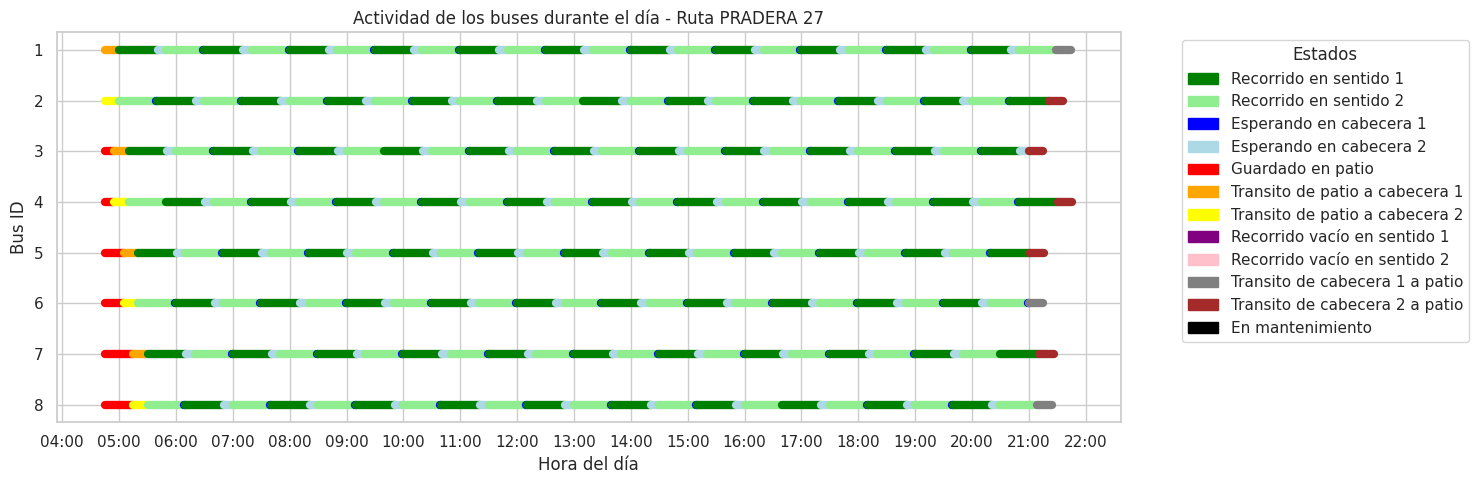

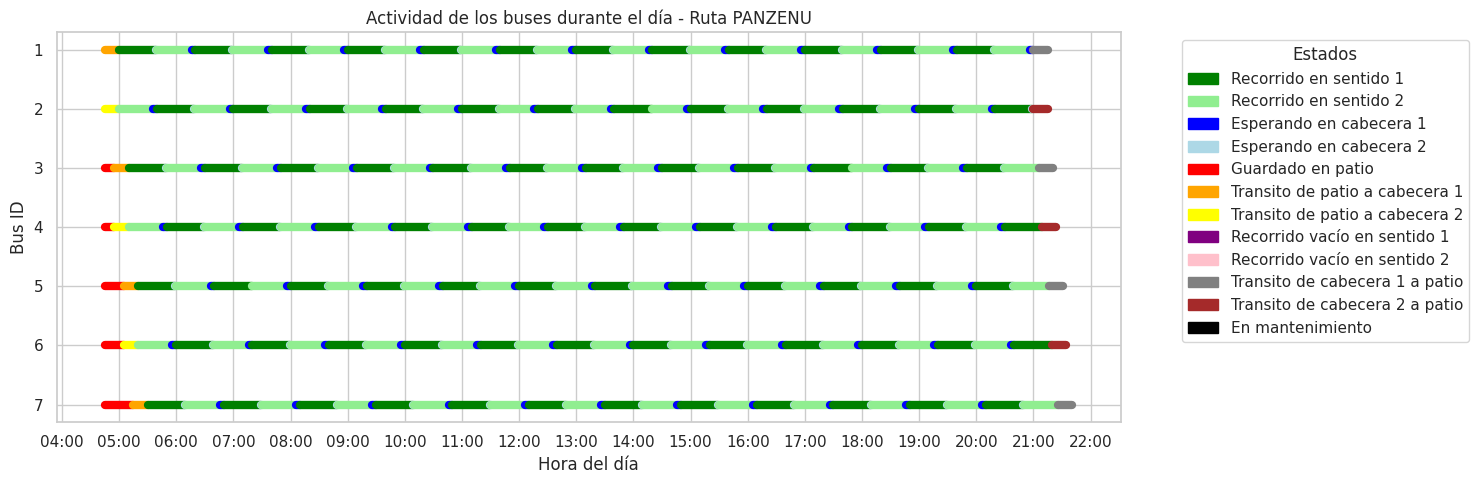

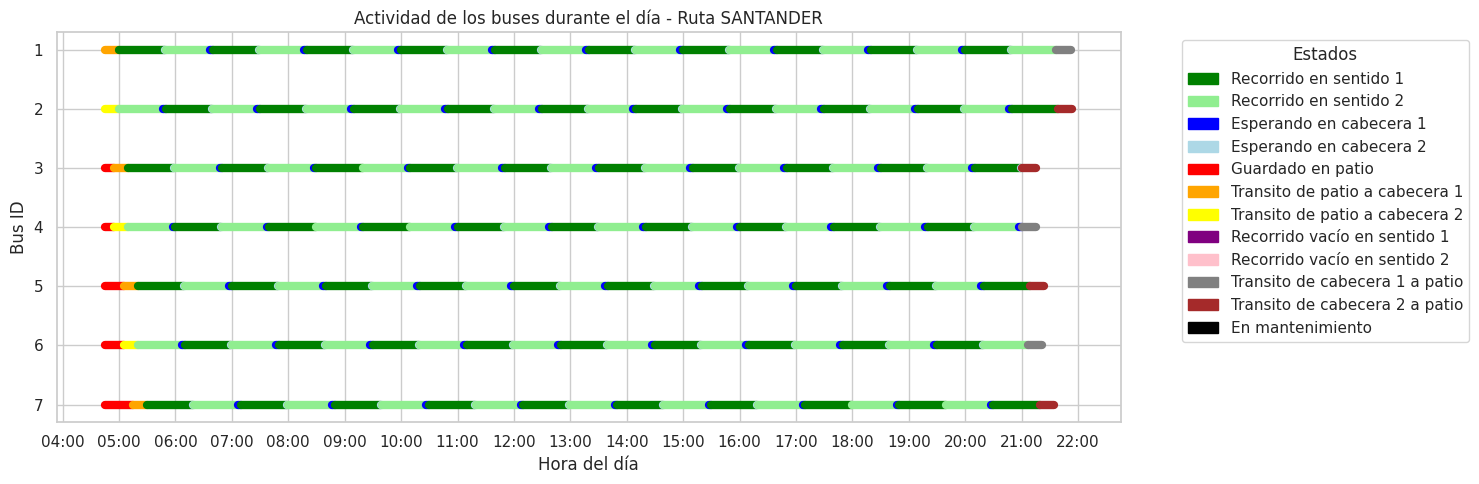

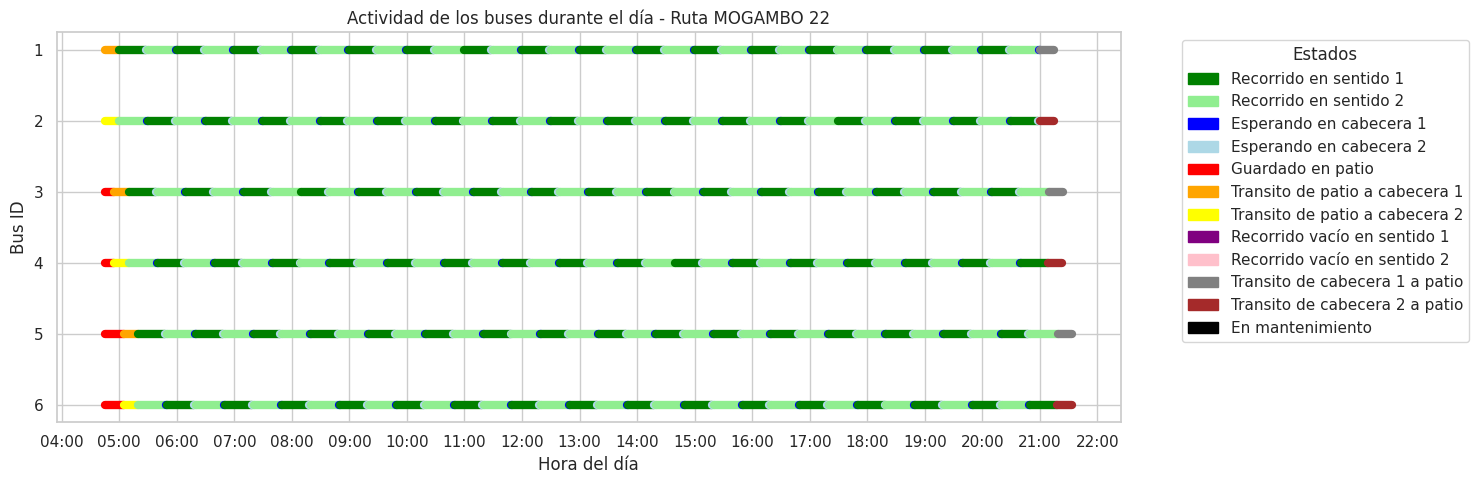

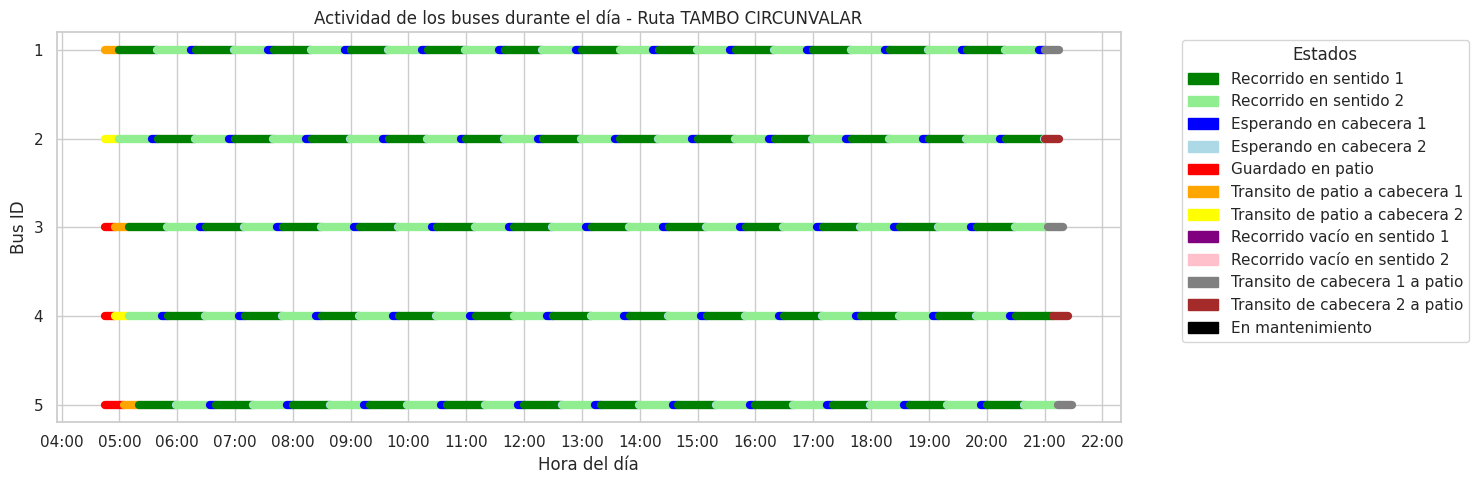

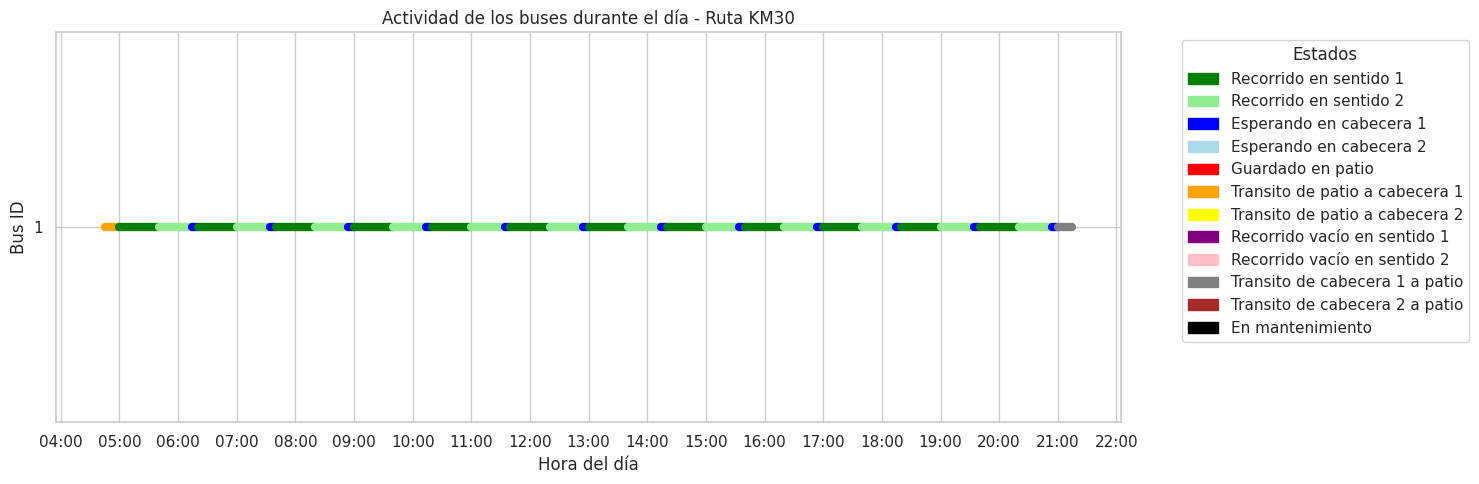

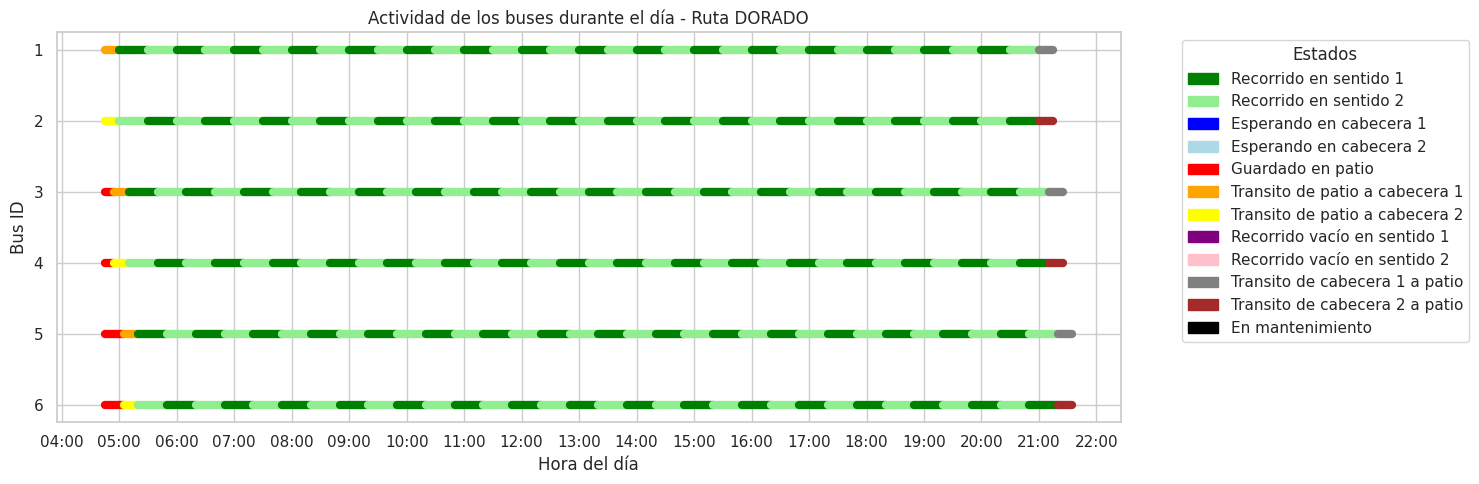

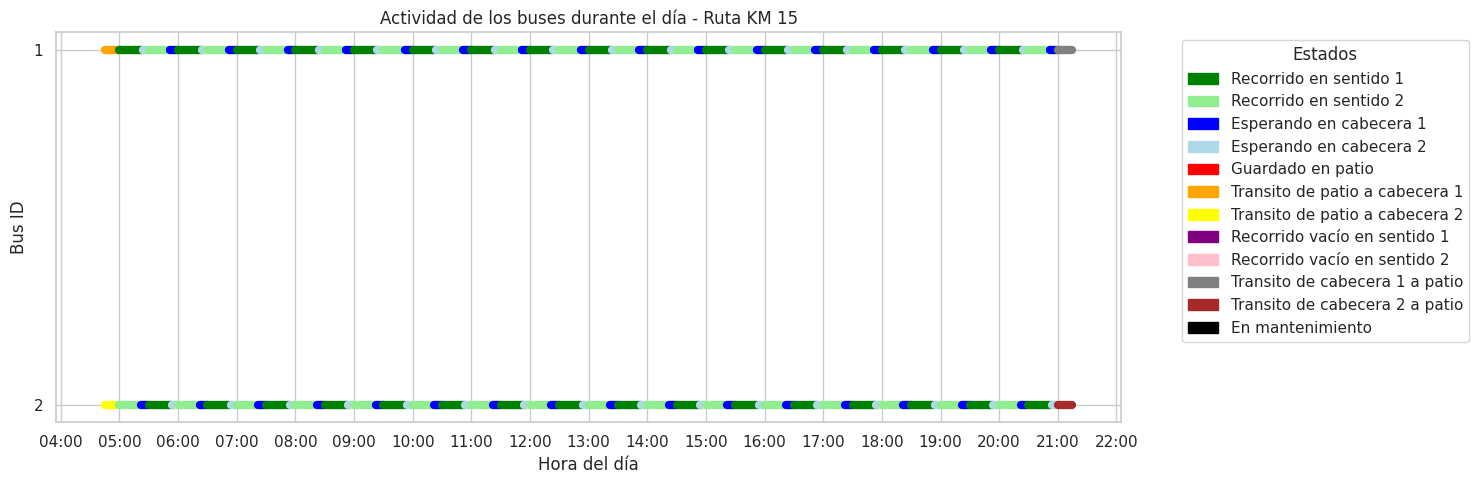

In [ ]:
# Visualización Gantt: Actividad de los buses durante el día para la configuración final

for ruta, config in rutas_config_final.items():
    df_registros = pd.DataFrame(config['registros'], columns=["Bus ID", "Estado", "Hora de Inicio", "Hora de Fin"])

    estado_labels = {
        "en_ruta_1": "Recorrido en sentido 1",
        "en_ruta_2": "Recorrido en sentido 2",
        "en_cabecera_1": "Esperando en cabecera 1",
        "en_cabecera_2": "Esperando en cabecera 2",
        "en_patio": "Guardado en patio",
        "en_transito_patio_cabecera_1": "Transito de patio a cabecera 1",
        "en_transito_patio_cabecera_2": "Transito de patio a cabecera 2",
        "en_vacio_1_a_2": "Recorrido vacío en sentido 1",
        "en_vacio_2_a_1": "Recorrido vacío en sentido 2",
        "en_transito_cabecera_1_patio": "Transito de cabecera 1 a patio",
        "en_transito_cabecera_2_patio": "Transito de cabecera 2 a patio",
        "en_mantenimiento": "En mantenimiento",
    }

    color_map = {
        "en_ruta_1": "green",
        "en_ruta_2": "lightgreen",
        "en_cabecera_1": "blue",
        "en_cabecera_2": "lightblue",
        "en_patio": "red",
        "en_transito_patio_cabecera_1": "orange",
        "en_transito_patio_cabecera_2": "yellow",
        "en_vacio_1_a_2": "purple",
        "en_vacio_2_a_1": "pink",
        "en_transito_cabecera_1_patio": "grey",
        "en_transito_cabecera_2_patio": "brown",
        "en_mantenimiento": "black",
    }

    plt.figure(figsize=(15, 5))
    for bus_index, bus_id in enumerate(df_registros["Bus ID"].unique(), start=1):
        bus_data = df_registros[df_registros["Bus ID"] == bus_id]
        for _, row in bus_data.iterrows():
            plt.plot(
                [row["Hora de Inicio"], row["Hora de Fin"]],
                [bus_index, bus_index],
                color=color_map.get(row["Estado"], "cyan"),
                lw=6
            )

    plt.yticks(
        ticks=range(1, len(df_registros["Bus ID"].unique()) + 1),
        labels=range(1, len(df_registros["Bus ID"].unique()) + 1)
    )
    legend_patches = [mpatches.Patch(color=color_map[state], label=estado_labels[state]) for state in color_map]
    plt.legend(handles=legend_patches, title="Estados", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Hora del día")
    plt.ylabel("Bus ID")
    plt.title(f"Actividad de los buses durante el día - Ruta {ruta}")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<ipython-input-14-5d0c3e4ce7b8>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab20", len(bus_ids))  # color distinto por bus


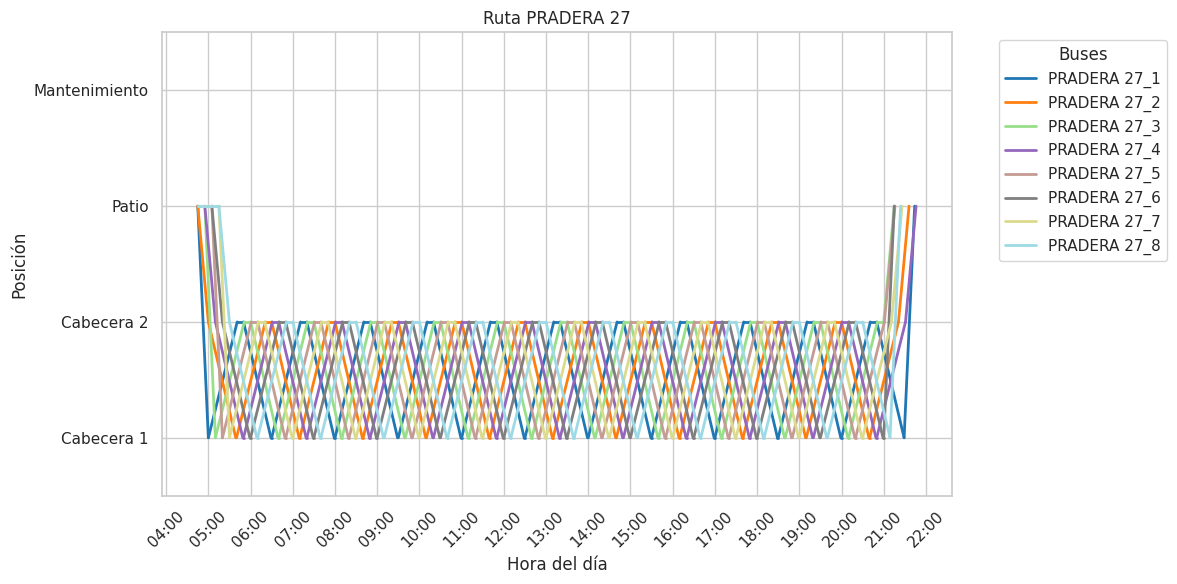

<ipython-input-14-5d0c3e4ce7b8>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab20", len(bus_ids))  # color distinto por bus


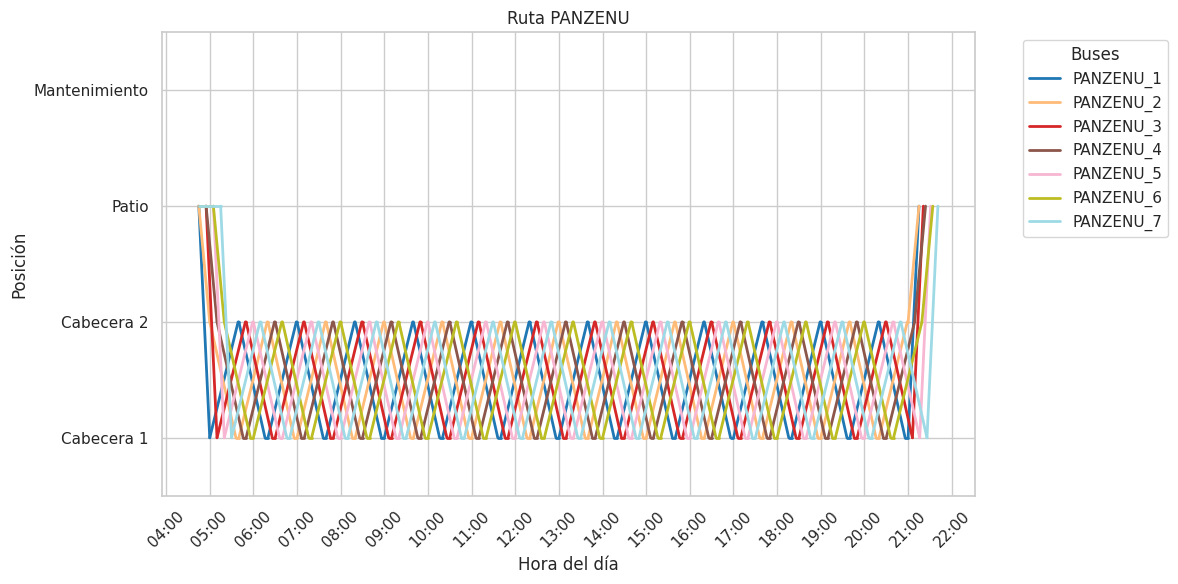

<ipython-input-14-5d0c3e4ce7b8>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab20", len(bus_ids))  # color distinto por bus


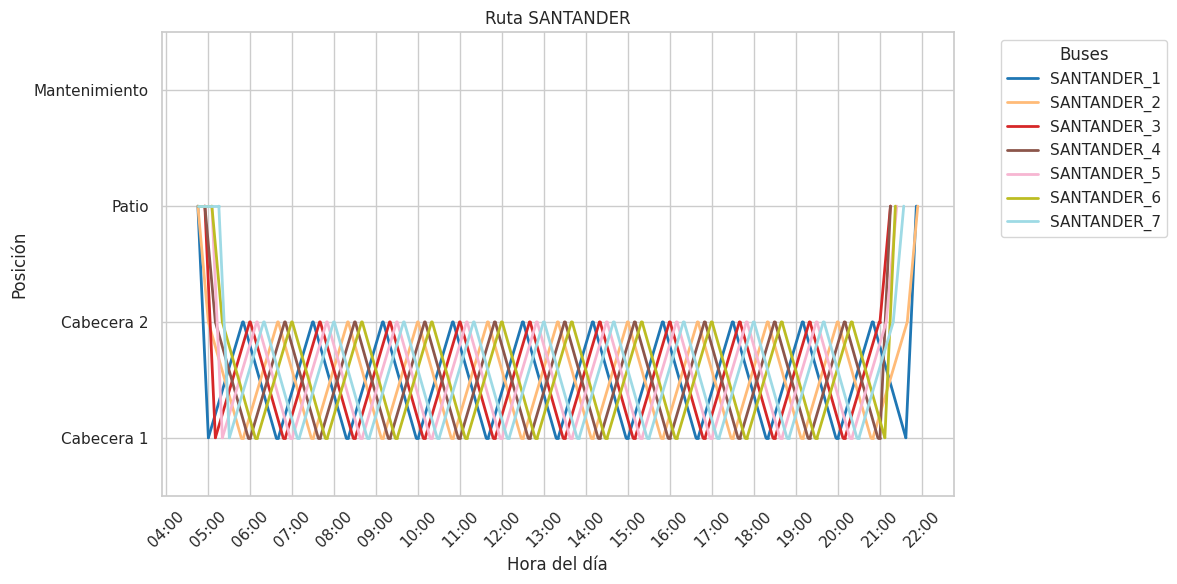

<ipython-input-14-5d0c3e4ce7b8>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab20", len(bus_ids))  # color distinto por bus


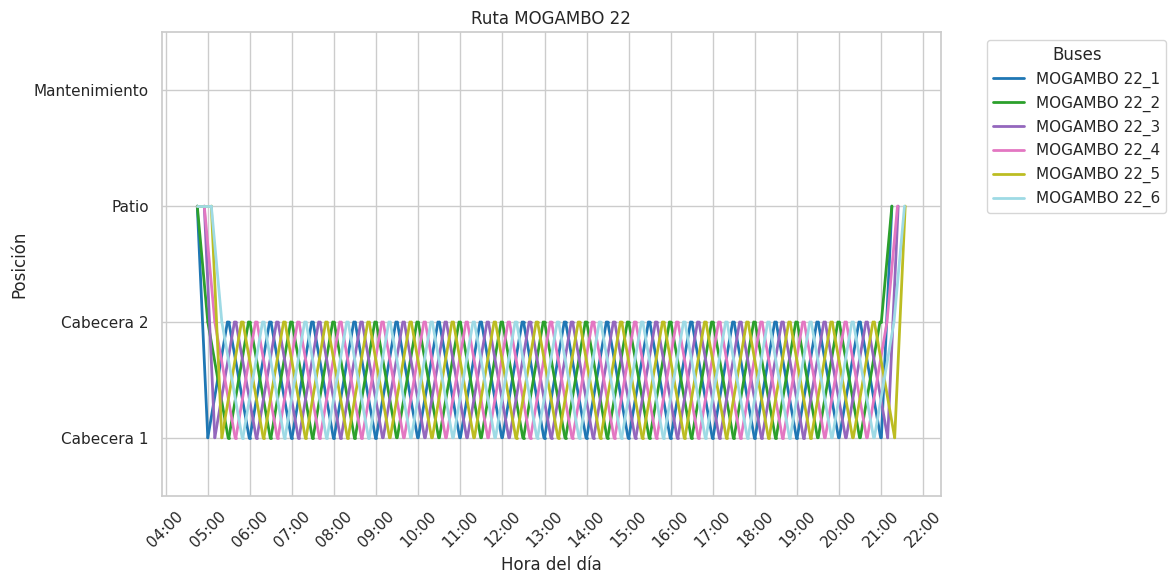

<ipython-input-14-5d0c3e4ce7b8>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab20", len(bus_ids))  # color distinto por bus


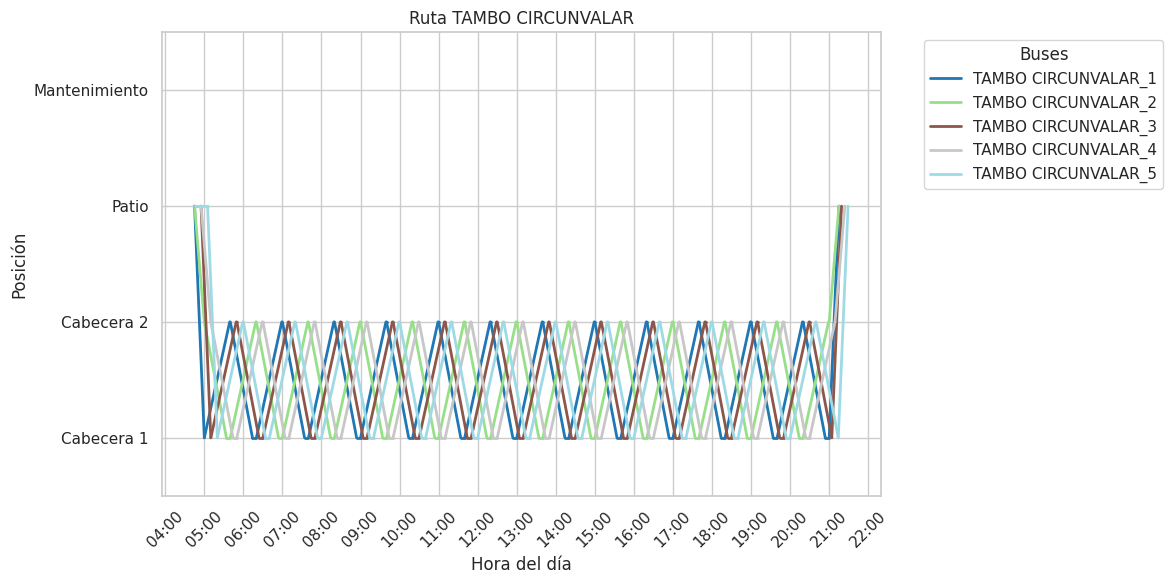

<ipython-input-14-5d0c3e4ce7b8>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab20", len(bus_ids))  # color distinto por bus


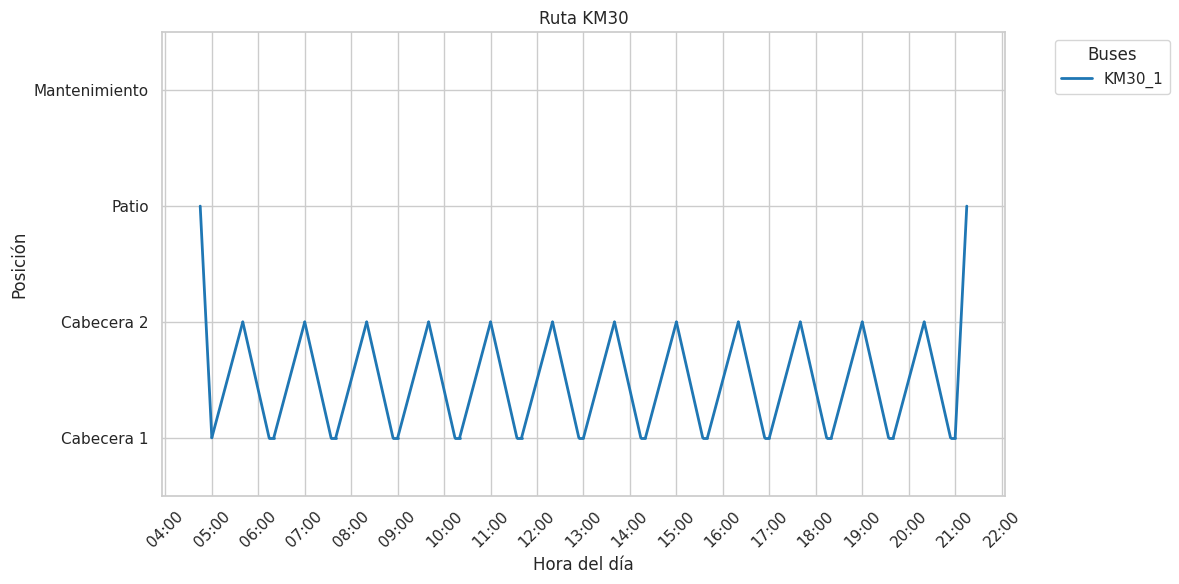

<ipython-input-14-5d0c3e4ce7b8>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab20", len(bus_ids))  # color distinto por bus


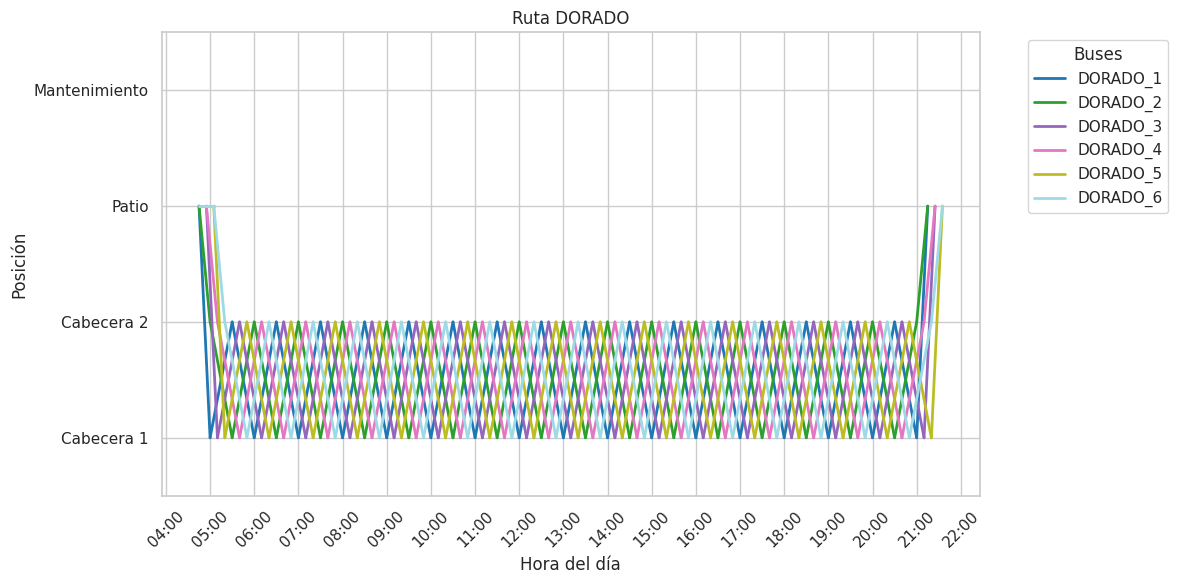

<ipython-input-14-5d0c3e4ce7b8>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab20", len(bus_ids))  # color distinto por bus


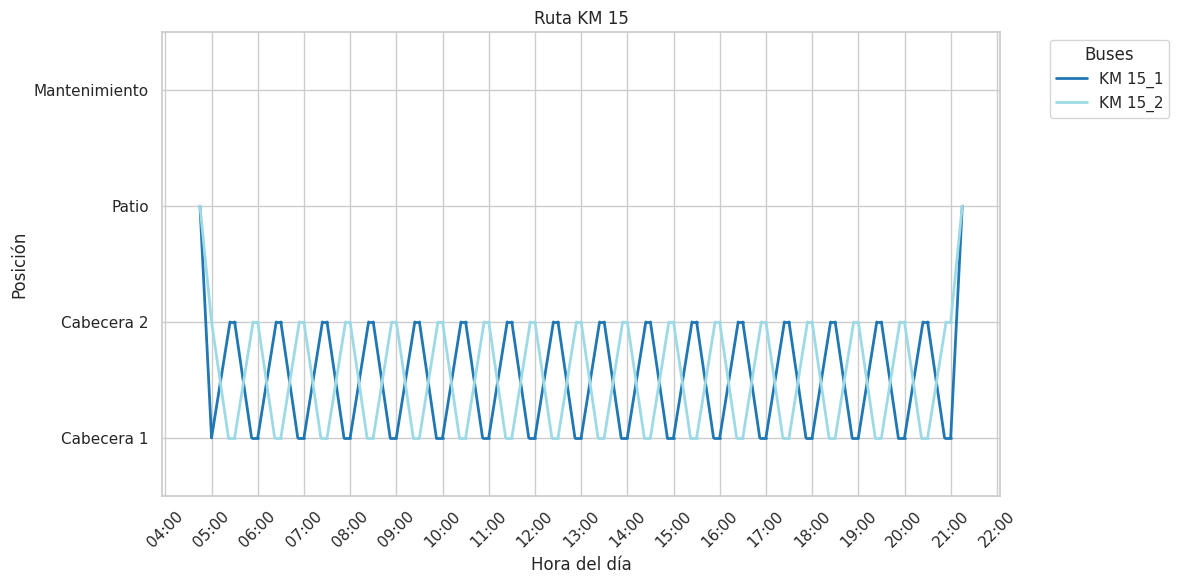

In [ ]:
# Estados “quietos” en una sola posición
position_map = {
    "en_cabecera_1": 1,
    "en_cabecera_2": 2,
    "en_patio": 3,
    "en_mantenimiento": 4,
}

# Estados “de tránsito” (tienen inicio y fin distintos en Y)
# Cada estado mapea a una tupla (y_inicial, y_final)
transition_map = {
    "en_ruta_1": (1, 2),   # de cabecera_1 a cabecera_2
    "en_ruta_2": (2, 1),   # de cabecera_2 a cabecera_1

    "en_transito_cabecera_1_patio": (1, 3),
    "en_transito_cabecera_2_patio": (2, 3),
    "en_transito_patio_cabecera_1": (3, 1),
    "en_transito_patio_cabecera_2": (3, 2),

    "en_vacio_1_a_2": (1, 2),
    "en_vacio_2_a_1": (2, 1),

    "en_mantenimiento": (4, 4),
}

def get_position_pair(estado):
    """
    Retorna (y_start, y_end) para el estado dado.
    Si el estado es fijo, y_start = y_end;
    si es de transición, se busca la tupla en transition_map.
    """
    if estado in position_map:
        y = position_map[estado]
        return (y, y)  # horizontal
    elif estado in transition_map:
        return transition_map[estado]
    else:
        # Por si se presenta un estado no contemplado
        return (None, None)


def plot_train_graph(rutas_config):
    """
    Genera un gráfico de tipo 'Train Graph' para cada ruta,
    usando los registros de estados en rutas_config[ruta]['registros'].
    """
    for ruta, config in rutas_config.items():
        # Convertir la lista de registros a DataFrame para filtrar fácilmente
        df_registros = pd.DataFrame(
            config['registros'],
            columns=["Bus ID", "Estado", "Hora de Inicio", "Hora de Fin"]
        )

        plt.figure(figsize=(12, 6))

        # Para una mejor visualización, haremos que cada bus tenga su propio color
        bus_ids = df_registros["Bus ID"].unique()
        palette = plt.cm.get_cmap("tab20", len(bus_ids))  # color distinto por bus

        for i, bus_id in enumerate(bus_ids):
            bus_color = palette(i)
            bus_data = df_registros[df_registros["Bus ID"] == bus_id]

            # Recorrer cada registro de estado del bus
            for _, row in bus_data.iterrows():
                estado = row["Estado"]
                hora_ini = row["Hora de Inicio"]
                hora_fin = row["Hora de Fin"]

                y_start, y_end = get_position_pair(estado)
                if y_start is None or y_end is None:
                    # Estado desconocido; omitir o poner un default
                    continue

                plt.plot(
                    [hora_ini, hora_fin],
                    [y_start, y_end],
                    color=bus_color,
                    linewidth=2
                )

        # Ajustes de ejes y etiquetas
        plt.title(f"Ruta {ruta}")
        plt.xlabel("Hora del día")
        plt.ylabel("Posición")

        # Eje X formateado para horas
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
        plt.xticks(rotation=45)

        # Eje Y con nombres de posición
        # Aquí podrías armar un mapping inverso, o manualmente, p.ej.:
        plt.yticks(
            [1, 2, 3, 4],
            ["Cabecera 1", "Cabecera 2", "Patio", "Mantenimiento"]
        )
        plt.ylim(0.5, 4.5)  # para dar un poco de margen

        # Leyenda (opcional). En este ejemplo, la leyenda será por Bus ID.
        from matplotlib.lines import Line2D
        legend_elements = []
        for i, bus_id in enumerate(bus_ids):
            legend_elements.append(Line2D([0], [0], color=palette(i), lw=2, label=bus_id))
        plt.legend(handles=legend_elements, title="Buses", bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

plot_train_graph(rutas_config_final)

## 9. Dudas frecuentes

1. **¿Qué hacer si el cuaderno no encuentra el archivo de demanda pronosticada?**  
   - Verificar la variable `ruta_archivo`: debe apuntar exactamente al CSV con los pronósticos (incluyendo extensión y carpeta).  
   - Confirmar que la carpeta en Google Drive (o local) esté montada correctamente y que el archivo exista en la ubicación especificada.  
   - Si se usa Google Colab, revisar que el montaje de Google Drive siga activo (a veces expira la sesión) y repetir la conexión de ser necesario.

2. **¿Por qué el cuaderno puede tardar mucho en la ejecución del análisis de sensibilidad?**  
   - Cada combinación de valores para el umbral de despacho y el tiempo máximo de espera desencadena una simulación completa. Cuantos más valores en los rangos, mayor será el número de escenarios y, por ende, el tiempo de cómputo.  
   - Para reducir la duración, se recomienda probar primero con un rango acotado (por ejemplo, 2 o 3 valores representativos) y verificar resultados; posteriormente, ampliar el rango si se requiere mayor detalle.

3. **¿Por qué en ciertos horarios se despachan pocos autobuses aunque la demanda parezca alta?**  
   - La heurística combina el **umbral mínimo de ocupación** y el **tiempo máximo de espera**; si no se alcanza el umbral dentro del período definido, el sistema podría abstenerse de despachar un bus para evitar viajes vacíos.  
   - Revisar si el valor de `umbral_porcentaje` es demasiado alto en relación con la demanda promedio, o si el `tiempo_max_espera` resulta insuficiente para acumular pasajeros en horas pico.

4. **¿Por qué mi nivel de servicio es óptimo, pero la utilidad no es la esperada?**  
   - Es posible que, para alcanzar un nivel de servicio muy alto, se estén despachando buses con baja ocupación, elevando los costos operativos.  
   - Revisar la métrica “Métrica Compuesta” o la “Utilidad” al seleccionar parámetros. Un ligero sacrificio en el nivel de servicio podría mejorar notablemente la rentabilidad si evita despachos excesivamente vacíos.

5. **¿Cómo integrar la última predicción de demanda (generada en otro cuaderno) sin problemas?**  
   - Asegurarse de que el archivo CSV consolidado (por ejemplo, `pronosticos_futuros_consolidados.csv`) mantenga el mismo formato (nombres de columnas y rutas) que se utiliza en la configuración de este cuaderno.  
   - Reemplazar la ruta del archivo en la variable `ruta_archivo` y, en caso de cambios en el nombre de las rutas, actualizarlos también en `crear_configuracion_rutas()`.


## Pasos siguientes
- Actualizar el archivo de demanda predicha con datos más recientes para afinar los resultados.
- Ajustar los parámetros de mantenimiento y tiempos de patio/cabeceras de acuerdo con la operación real.
- Eventualmente, integrar un módulo de optimización más avanzado o algoritmos de aprendizaje para recomendar políticas de despacho que respondan a variaciones diarias en la demanda.


